In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.base import clone
import joblib
import plotnine as pn

from datasets import fetch_data_generator
from myflaml import auto_reg, auto_clf
from DRLinear import DRLinear
from cal_scorer import cal_scorer

In [2]:
pre_tuned_n = True
pre_tuned_dr = True

#### Prep Data

Semi-synthetic data on 401k savings

In [3]:
## For semi-synthetic data generation
data = '401k'
semi_synth = False # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = True # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
scale = .2 # magnitude of noise in semi-synthetic data

np.random.seed(712)
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]


get_data, abtest, true_cef, true_cate = fetch_data_generator(data=data, semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             scale=scale, true_f=simple_true_cef,
                                                             max_depth=max_depth)
X, D, y, groups = get_data()

In [4]:
# Split into training (X), validation (Xval), and test (Xtest) sub-samples
X, Xval, D, Dval, y, yval = train_test_split(X, D, y, train_size=.6, shuffle=True, random_state=123)
Xval, Xtest, Dval, Dtest, yval, ytest = train_test_split(Xval, Dval, yval, train_size=.5, shuffle=True, random_state=123)

#### Train Nuisance Models

In [5]:
time_budget = 120
groups = None
n_splits = 5
split_type = 'auto'
verbose = 0

In [6]:
# Tune hyper-parameters/find best prediction method (restricted here to xgboost)
if pre_tuned_n:
    mt, mreg_zero, mreg_one = joblib.load('nuisance.jbl')
    model_t = lambda: clone(mt)
    model_reg_zero = lambda: clone(mreg_zero)
    model_reg_one = lambda: clone(mreg_one)

else:
    model_reg_zero = auto_reg(X[D==0], y[D==0], groups=groups, n_splits=n_splits, split_type=split_type,
                              verbose=verbose, time_budget=time_budget)
    model_reg_one = auto_reg(X[D==1], y[D==1], groups=groups, n_splits=n_splits, split_type=split_type,
                             verbose=verbose, time_budget=time_budget)
    model_t = auto_clf(X, D, groups=groups, n_splits=n_splits, split_type=split_type,
                       verbose=verbose, time_budget=time_budget)

    joblib.dump([model_t(), model_reg_zero(), model_reg_one()], 'nuisance.jbl')

#### Get OOS Predictions

In [7]:
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
splits = list(cv.split(X, D))

n = X.shape[0]
reg_preds = np.zeros(n)
reg_zero_preds = np.zeros(n)
reg_one_preds = np.zeros(n)
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

DX = np.column_stack((D, X))
for train, test in splits:
    reg_zero = model_reg_zero().fit(X.iloc[train][D[train]==0], y[train][D[train]==0])
    reg_one = model_reg_one().fit(X.iloc[train][D[train]==1], y[train][D[train]==1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

prop_preds = cross_val_predict(model_t(), X, D, cv=splits)

#### DR Meta-Learner

In [8]:
# Subset of features used for treatment effect heterogeneity
hetero_feats = ['inc']
Z, Zval, Ztest = X[hetero_feats], Xval[hetero_feats], Xtest[hetero_feats]

In [9]:
# Calculate DR outcomes
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .01, np.inf)

In [10]:
# # Predict DR outcomes using Z
if pre_tuned_dr:
    drlearner_best = joblib.load('drlearner.jbl')
    drlearner = drlearner_best.fit(Z, dr_preds)
else:
    model_final_fn = lambda Z, y: auto_reg(Z, y, groups=groups, n_splits=n_splits, split_type=split_type,
                                           verbose=verbose, time_budget=time_budget)
    drlearner_best = model_final_fn(Z, dr_preds)
    joblib.dump(drlearner_best(), 'drlearner.jbl')

In [11]:
# Fit nuisance models using the entire training sample
reg_zero = model_reg_zero().fit(X[D == 0], y[D == 0])
reg_one = model_reg_one().fit(X[D == 1], y[D == 1])
reg_t = model_t().fit(X, D)

### Linear Regression Validation

In [12]:
my_drlinear = DRLinear(drlearner, reg_zero, reg_one, reg_t)

print(my_drlinear.fit(Xval, Dval, yval, Zval).params)

[-2.46287569e+03  9.31530627e-01]


### Calibration Validation

In [13]:
my_cal_scorer = cal_scorer(drlearner, reg_zero, reg_one, reg_t, 4)
res_cal = my_cal_scorer.score(Xval, Dval, yval, Zval, Ztest)

df_cal = pd.DataFrame({'gate': res_cal.gate, 'g_cate': res_cal.g_cate,
                       'se_gate': res_cal.se_gate})
df_cal['lb_gate'] = df_cal.gate - 1.96 * df_cal.se_gate
df_cal['ub_gate'] = df_cal.gate + 1.96 * df_cal.se_gate

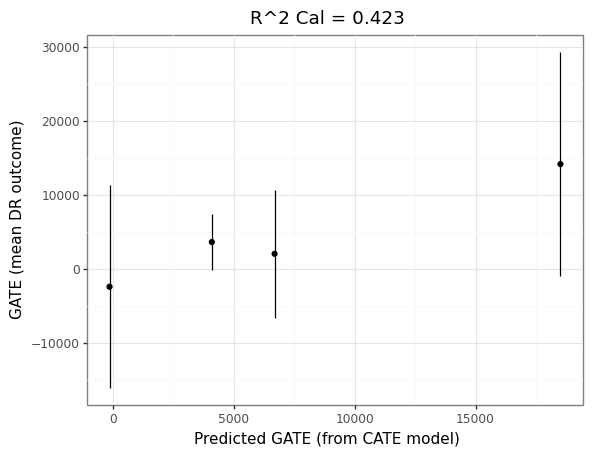

<ggplot: (8792589719146)>

In [14]:
(
    pn.ggplot(df_cal) +
        pn.aes(x = 'g_cate', y = 'gate', ymin = 'lb_gate', ymax = 'ub_gate') +
        pn.geom_point() +
        pn.geom_errorbar() +
        pn.labs(x = 'Predicted GATE (from CATE model)', y = 'GATE (mean DR outcome)',
                title = 'R^2 Cal = ' +  str(round(res_cal.r_squared_cal, 3))) +
        pn.theme_bw()

)